In [1]:
### Optional cell for DCML users tests: the following libraries are needed to 
### be installed for the library to work. Run this cell to install them if they
### are not yet. Maybe you'll have to replace `pip` by `pip3` or the conda install 
### command depending how you have python3 ready to be used on you machine.

!pip install music21
!pip install pretty_midi
!pip install madmom
!pip install matplotlib

zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


This tutorial showcases how to draw a single wavescape using the "generate_single_wavescape" function from the "wavescapes" python module. All the different parameters and customization options from this function are presented with meaningful examples. The goal of this tutorial is only to show how to use the library; for explanations of the visualization's methodology and how to interpret wavescapes, please refer to [the official publication from Musicae Scientiae (dead link as it is not yet published)](dead)

Before beginning, be sure the module "wavescapes" and all its dependencies are properly installed on your machine or virtual environnement ( `pip install wavescapes`). ( _Note for DCML users tests: step not required as long as you are running this notebook on a local clone of the repo_ ). Run the cell below to check if the module was properly installed. 

In [2]:
'''
The shell line below will be removed once the last version of the library 
is publicly available through pip. Its purpose for now is just to redirect
the source code of the repo in the same place as this notebook.
'''
!ln -s ../wavescapes wavescapes

from wavescapes import generate_single_wavescape

ln: wavescapes/wavescapes: File exists


All examples in this notebook are computed from the same input file, which is the _Prelude in C Major_ from J. S. Bach (BWV 846). The version used in this repository comes from this [publicly available transcription in XML format](https://musescore.com/classicman/scores/210606) and is already downloaded and ready to use in the "inputs" folder located in the same directory as this notebook. The line below checks if the file is present and loads its path in the 'bach_prelude_fp' variable which is used all throughout this notebook.

In [3]:
import os

bach_prelude_fp = 'inputs/Prelude_No._1_BWV_846_in_C_Major.mxl'

if not os.path.isfile(bach_prelude_fp):
    raise Exception("'%s' does not exist."%bach_prelude_fp)

The library accepts two types of inputs: symbolic data and real audio data. Audio processing for wavescapes is explained in the tutorial notebook number 2, thus this notebook focuses solely on symbolic data in MIDI format, or XML/XML/MusicXML formats. The library acts the same way regardless of the symbolic data format, hence why we only show examples obtained from an XML file.

For ease of navigation, here is the table of contents with skiplinks to directly get to the different parts presented in this notebook. If it is your first time with the library, we strongly recommand you follow this notebook in sequential order, running each cell one after the other.

# Table of Contents

1. [Base case](#base)
    1. Select an analysis window length (and its implication for the resulting plot)
2. [Horizontal ticks for bar number](#horizontalticks)
    1. Defining “tick_ratio” parameter as a measure of drawing primitive per tick/bar 
    2. Defining “tick_offset” parameter as a way to account the 0th bar
    3. Defining "tick_factor" parameter as a way to reduce the number of ticks on large pieces
3. [Vertical indicators for hierarchical markers](#verticalticks)
    1. Define “indicator_size” as a factor of a size
4. [Highlight & partitioning](#highlights)
    1. Drawing multiples highlights on a single wavescape
    2. Producing “subwavescapes”
5. [Cosmetic changes](#comsetic)
    1. Adding line delimiters between primitives
    2. Different drawing primitives (rhombus, diamonds, and hexagons)
    3. True Opacity and its caveat 
6. [Saving figures](#saving)
    1. Saving
    2. Adding a wavescape as a matplotlib subfigure
7. [Other parameters](#other)
    1. Removing tracks/parts that are unpitched
    2. Adding a label on the top left corner
    3. Triming silences at both extremeties of the piece

<a id='base'></a>
# Base case

The function "generate_single_wavescape" takes three mandatory arguments:

* `filepath`, a string representing the path of the input file.
* `pixel_width`, an integer representing the width in pixel of the resulting plot, assuming a DPI (dot per inch) of 96.
* `coefficient`, a positive integer between 1 and 6 included which is the Fourier coefficient to be displayed in the plot.

Although not mandatory, the parameter '`aw_size`', a float, should often be specified as it represents the size of the "analysis window" which corresponds to the size of the shortest segments of the wavescapes (the ones that fills to bottom most row). The unit of this argument for symbolic data is a quarter note, and by default, is set to 1.0, meaning the input score is segmented in `N` non-overlapping chunks of quarter notes. The wavescapes feature `0.5*N^2` individual elements, so `aw_size` **is crucial to the performance of the algorithm, the smaller its value is, the more sharp the visual plots produced is, but bigger is the time taken to generate it**.

The line below thus generates the wavescape of the fifth coefficient on Bach's prelude with a width of 500 pixels, and an analysis window's default size of one quarter note.

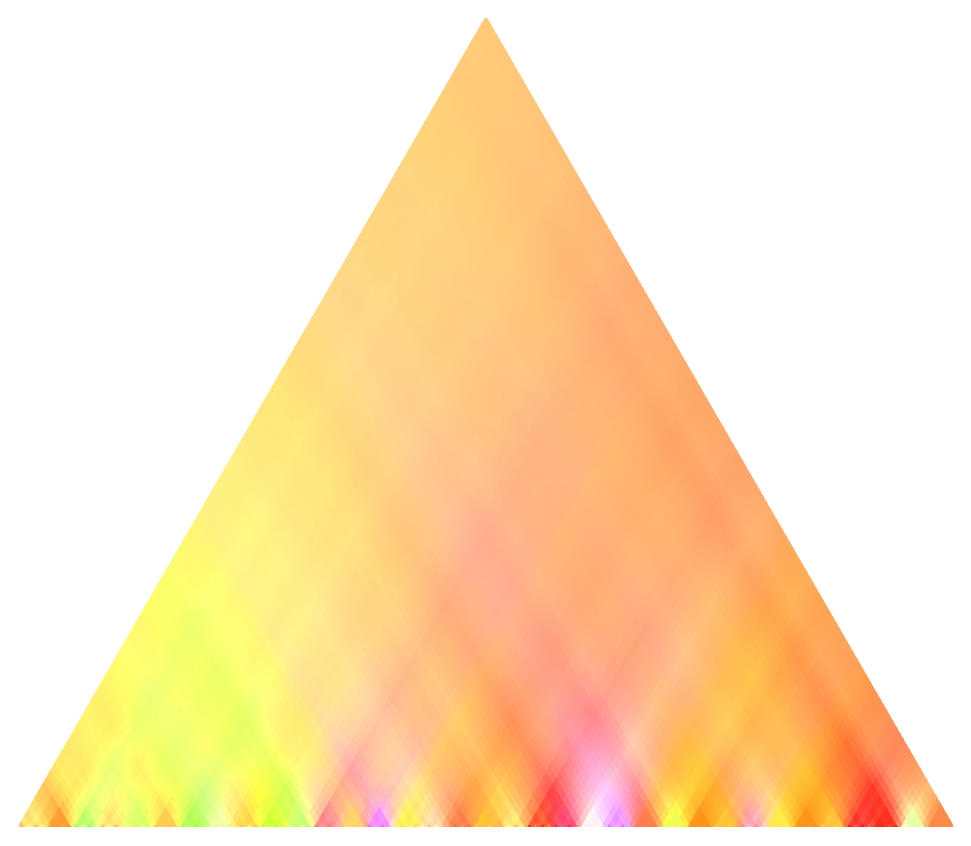

In [4]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5)

If we want to have the visual resolution of one color per bar, the value of 4.0 needs to be given to `aw_size`, as the time signature of the Prelude is 4/4, i.e. 4 quarter notes per bar: 

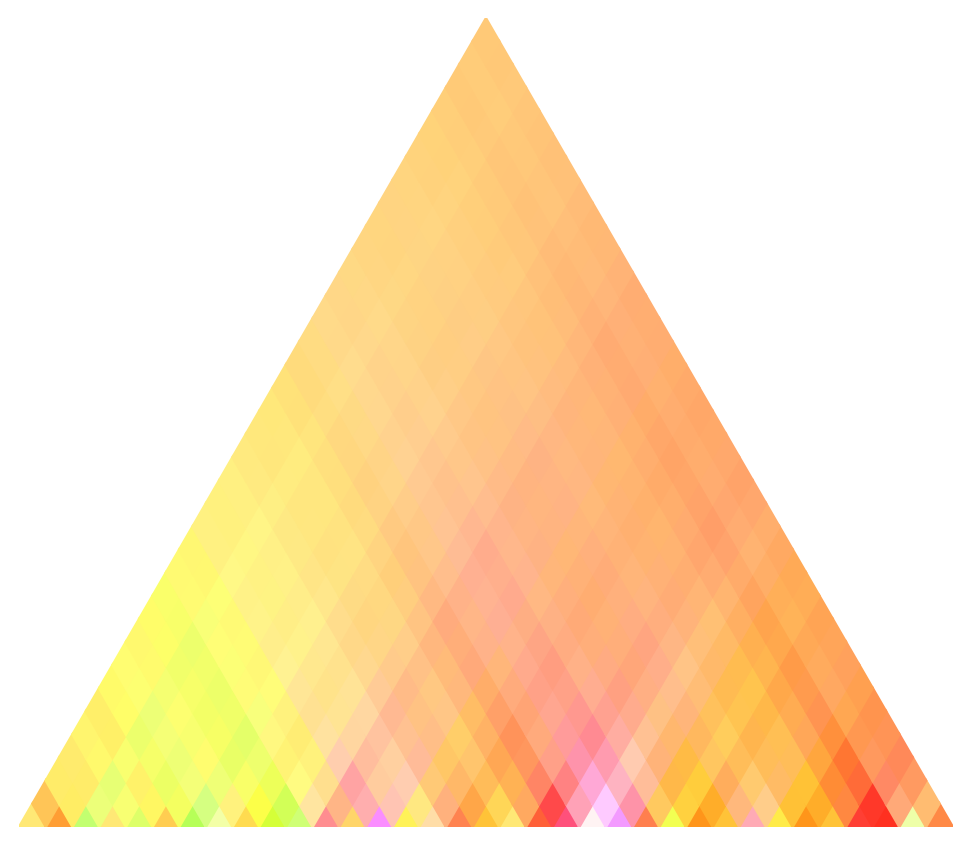

In [5]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, aw_size=4.0)

<a id='horizontalticks'></a>
# Horizontal ticks for bar number

Without horizontal markers, it can be hard to understand to which section of the piece a certain color in the plot corresponds. The parameter `tick_ratio`, a positive integer, exists to solve this problem: It represents after how many "chunks" from the bottom-most row one tick needs to be drawn on the horizontal axis (in other word, the _ratio_ of analysis window per _tick_ ). By default this parameter is set to `None`, which the function interprets as no horizontal ticks to be displayed.

If for example, we want each tick to represent a bar in the Prelude in C Major, by knowing its time signature is 4/4, and considering the default analysis window of one quarter note, `tick_ratio` with a value of 4 draws a tick per bar of the Prelude:

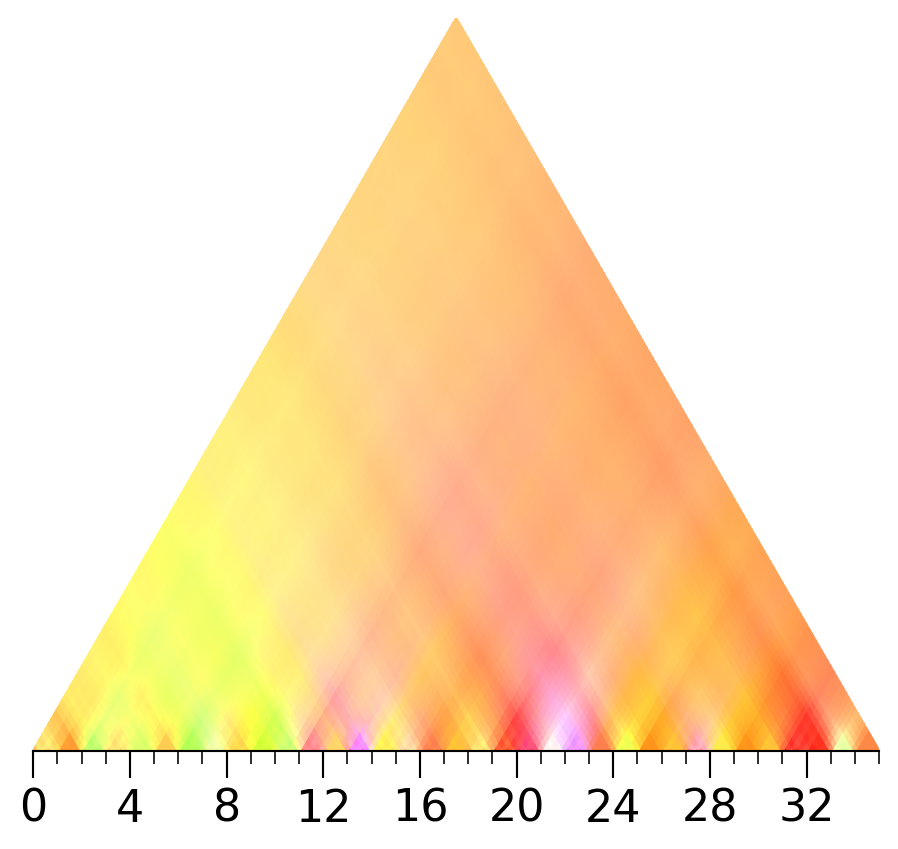

In [6]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, tick_ratio=4)

Although this is an accurate horizontal axis for the bar of the prelude, generally music score starts with bar number 1, and not 0. Setting `tick_offset`, another parameter of the function to the value 0 makes the tick starts at 1:

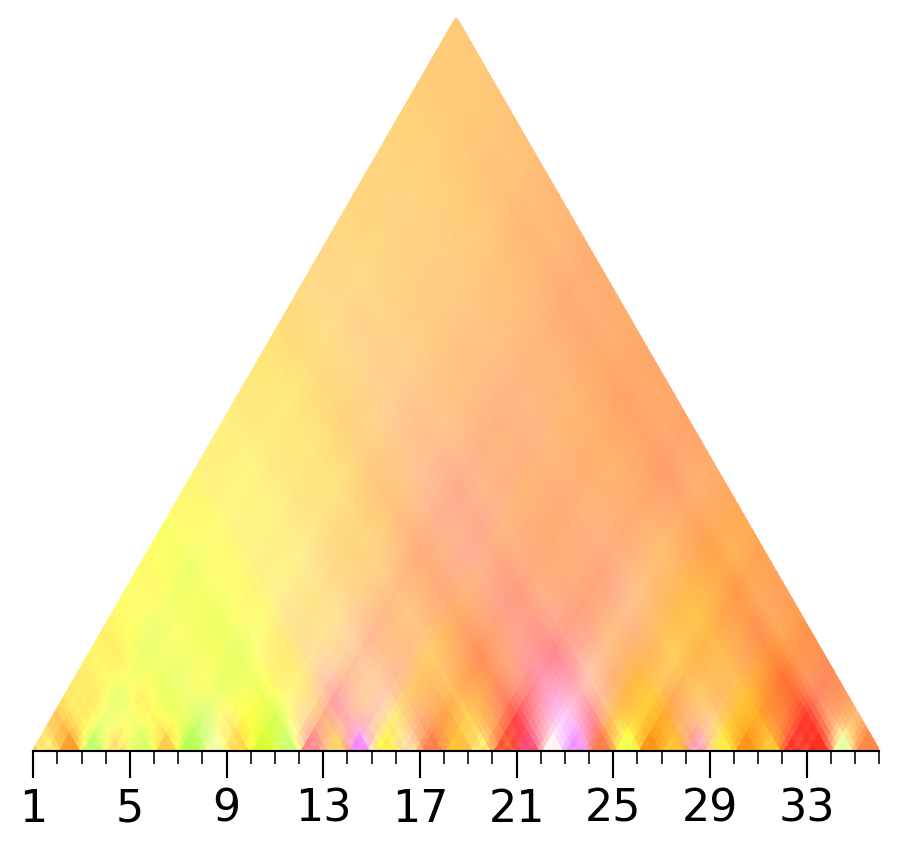

In [7]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, tick_ratio=4, tick_offset=0)

This parameter serves more purpose than indicating to the function to start ticks at 1. `tick_offset` is a positive integer valued between 0 and `tick_ratio` (non included) and serves as a way to correctly model pieces who have "pick-up bars" or "anacruses", i.e. notes played before the start of the first bar. 

Let's imagine that the Prelude in C Major if shifted by a half note to the left, and thus begins one half note before the first bar. To correctly represents the bar numbers in the wavescape, the value of 2 can be given to `tick_offset` which the function interprets as _offsetting_ the _ticks_ by two amounts of analysis window (since the analysis window is one quarter note, and two quarter notes forms a half note):

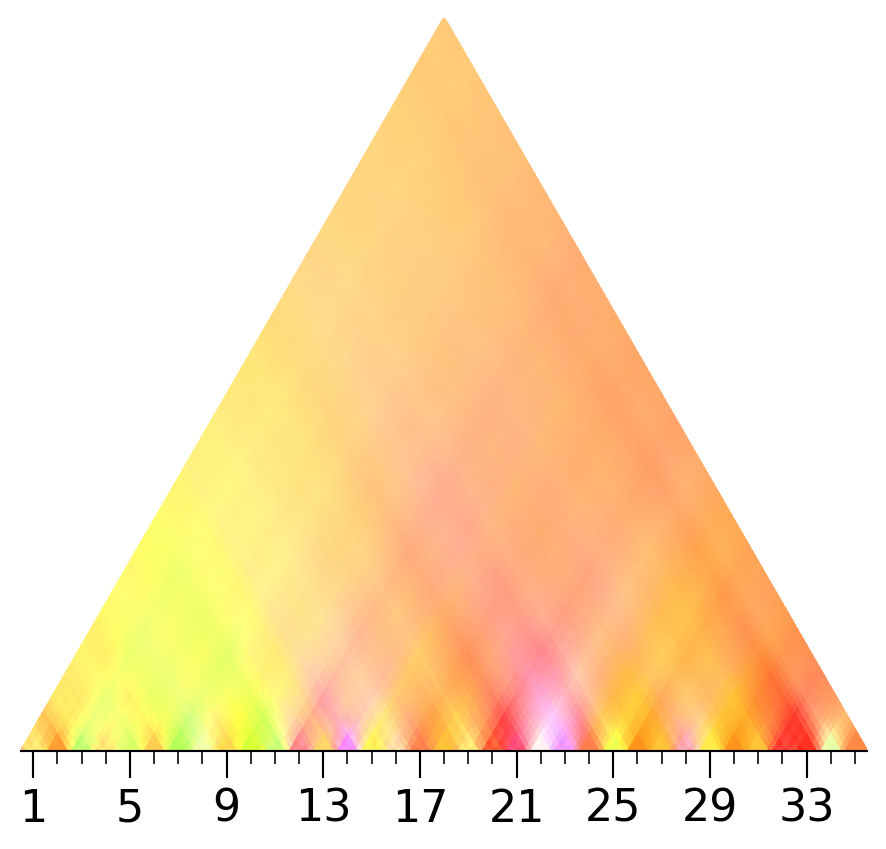

In [8]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, tick_ratio=4, tick_offset=2)

A third parameter, `tick_factor`, a positive float whose default value is 1.0, serves as a way to _factor_ the number displayed on _ticks_. Let's say we want to have one tick per quarter note on the Prelude, by setting `tick_ratio` and `aw_size` both to one:

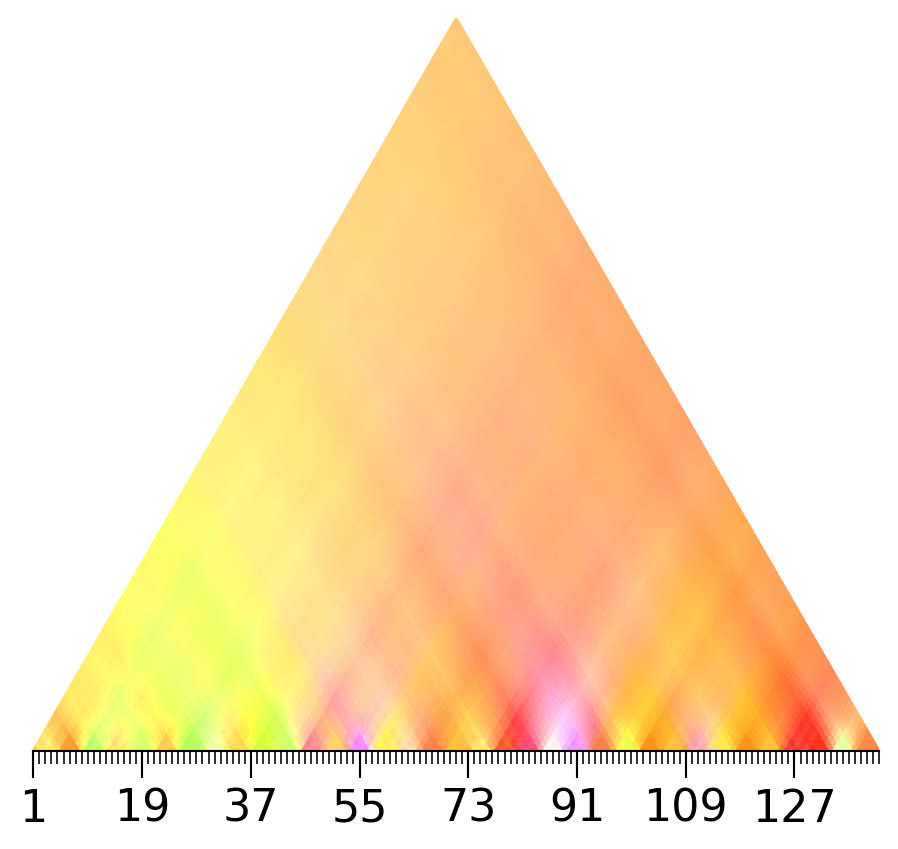

In [9]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, aw_size=1, tick_ratio=1, tick_offset=0)

The ticks now represent now the number of quarter note, but what if we want the number to still represent bar numbers, not quarter notes number? This can be achieved in this case by setting `tick_factor` to 0.25 (i.e. 1/4) to scale the number displayed on the ticks by one fourth:

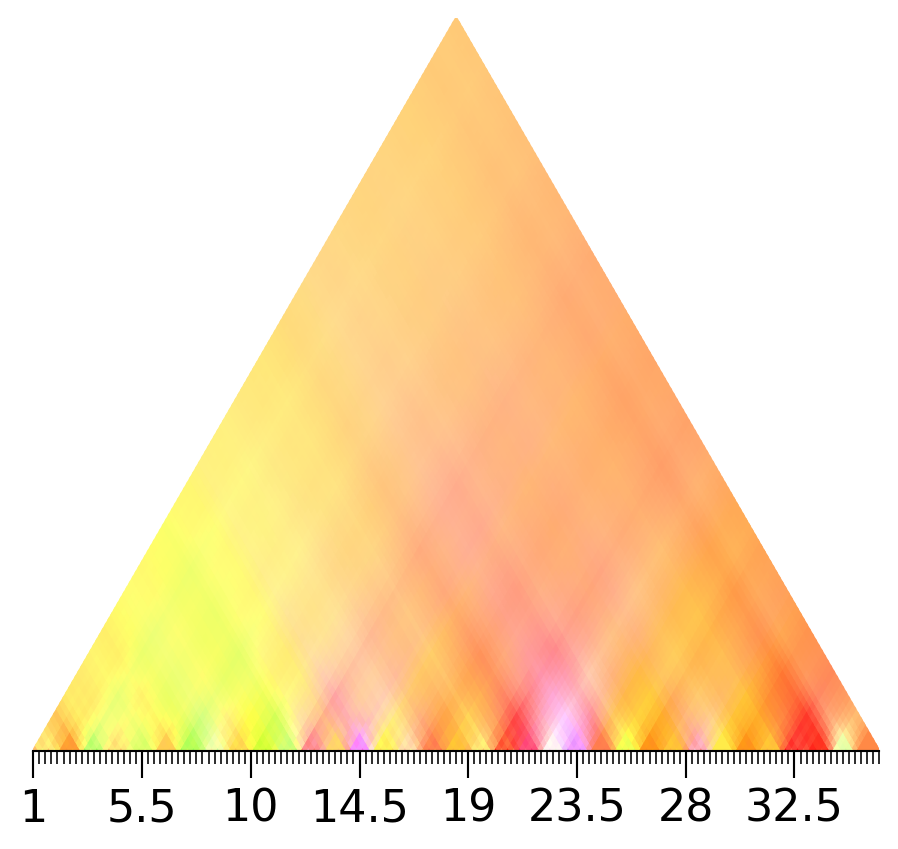

In [10]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=1, tick_ratio=1, tick_offset=0, tick_factor=0.25)

This works also the other way around, if we have `aw_size` set to 8 (two measure) and `tick_ratio` to 1, we have one tick per two bars, but having the number representing the bars is possible by _factoring_ the _ticks_ by 2:

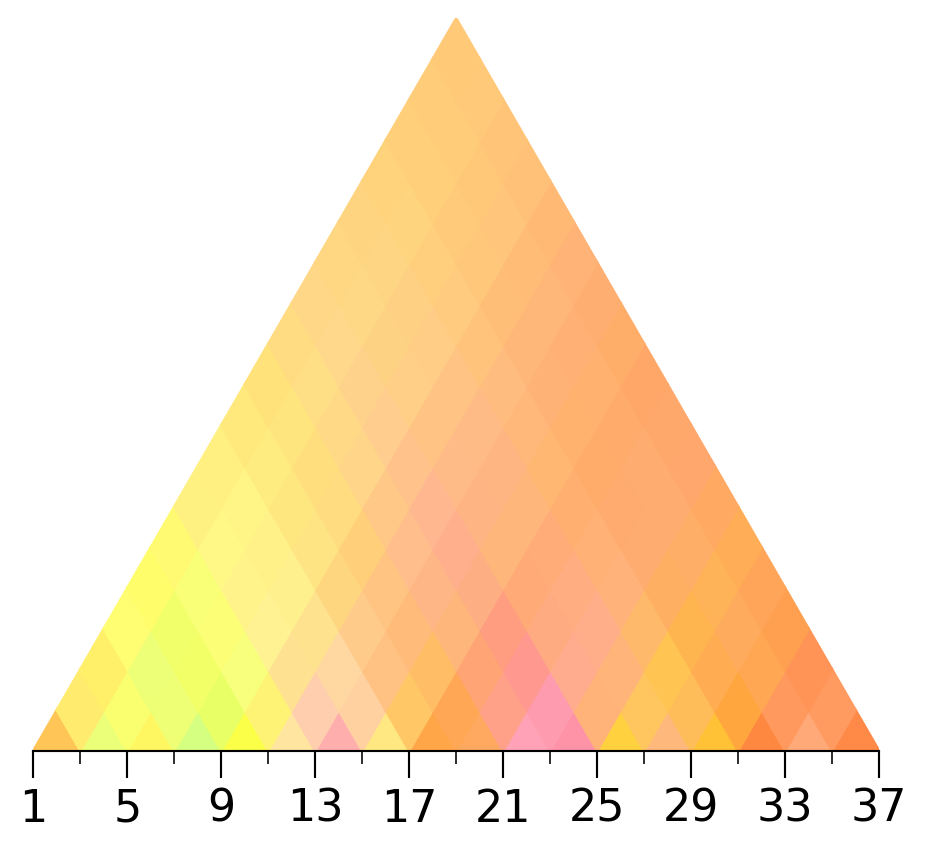

In [11]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=8, tick_ratio=1, tick_offset=0, tick_factor=2)

<a id='verticalticks'></a>
# Vertical indicators for hierarchical markers

In a similar fashion horizontal ticks are needed to understand the time placement of certain colors, vertical indicators are needed to help grasp the hierarchical levels displayed in the wavescapes.

The parameter `indicator_size`, a positive float, exists for this purpose. Its default value is `None` which the function interprets as "do not to display such indicators". Otherwise the recommanded value is 1.0, and represents the relative size of 7 rounded indicators that are put on each side of the wavescape. They are placed at each eight subdivision of the length of the side of the wavescape: 

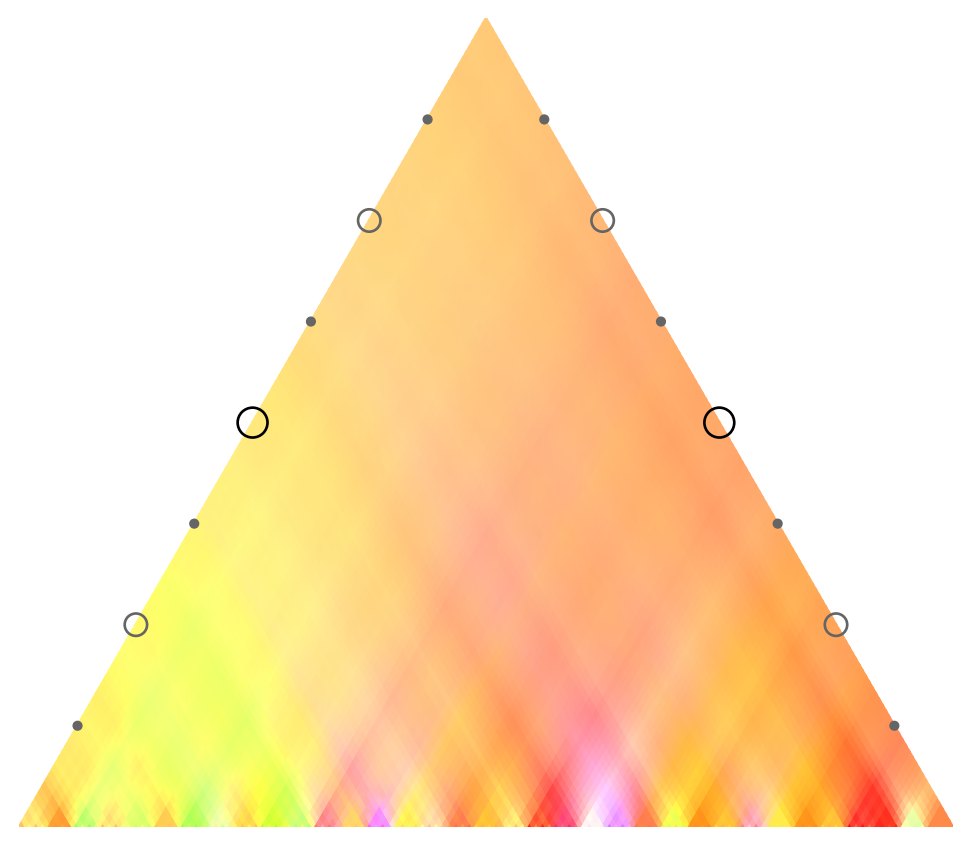

In [12]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, indicator_size=1.0)

The biggest indicator is the middle one, the black circle, whose center represents the hierarchical level of all segments whose length is half the length of the piece. The two smaller gray circle represent from bottom to top, the levels of segments of 1/4 and 3/4 the length of the piece, while the 4 remaining indicators represent the levels of segements of 1/8, 3/8, 5/8 and 7/8 the length of the piece respectively.

Decreasing (resp. increasing) the value of `indicator_size` decreases (resp. increases) the relative radius of each of those indicator:

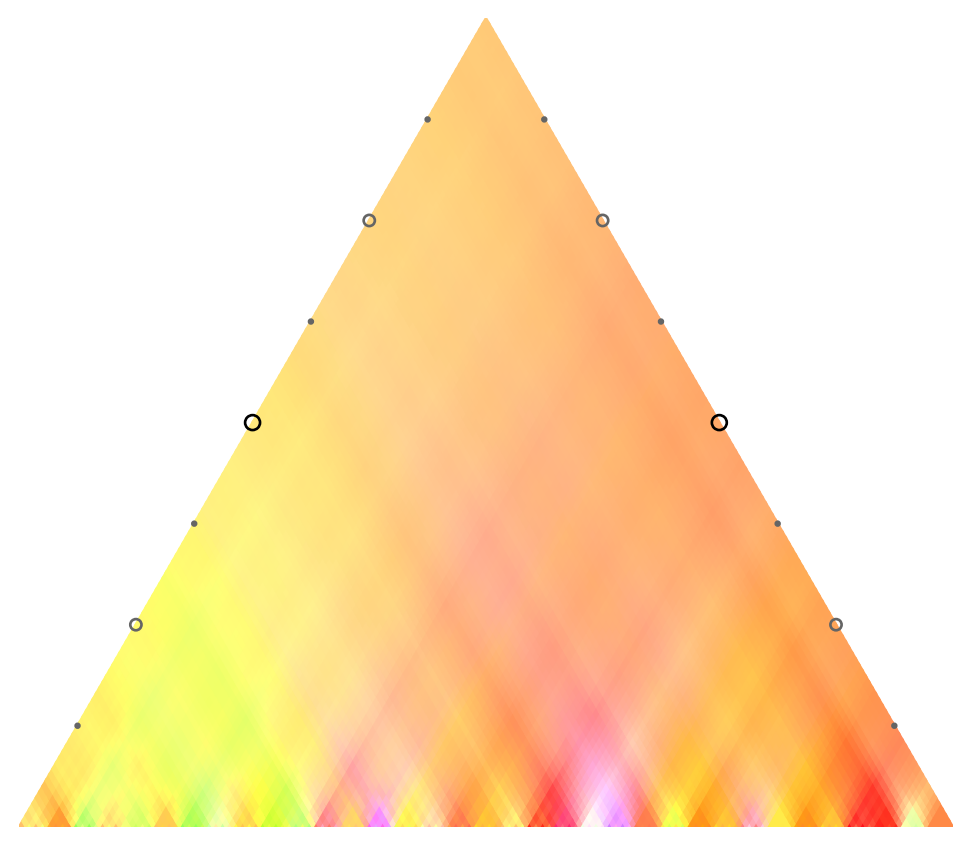

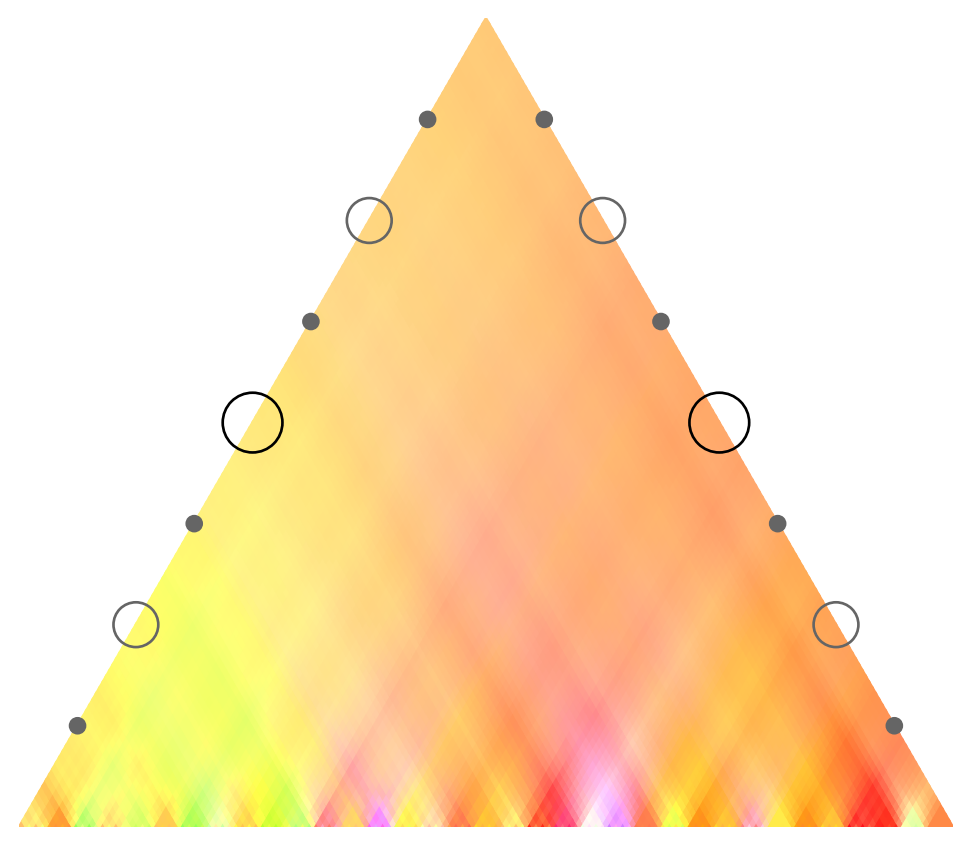

In [13]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, indicator_size=0.5)
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, indicator_size=2)

<a id='highlights'></a>
# Highlights & partitioning

Sometimes it might be useful to "zoom in" on a particular part of the wavescape in order to decipher all individual colored elements. The parameter `subparts_highlighted` exists partly for this purpose. It expects an 1x2 array or tuples of integer, which represent the onset and offset of the part to be "zoomed-in" in terms of index of analysis window. 

For instance, let's say we want to observe more closely the region from bar 19 to 24, as it is the only part of the wavescapes that feature white. If we keep an analysis window of one quarter note, that means we want to observe the sub region from the 72th (`(19-1)* 4`) segment to the 96th, thus the value `[72, 96]` can be given to `subparts_highlighted` for zooming in on this particular _subpart_ of the piece:

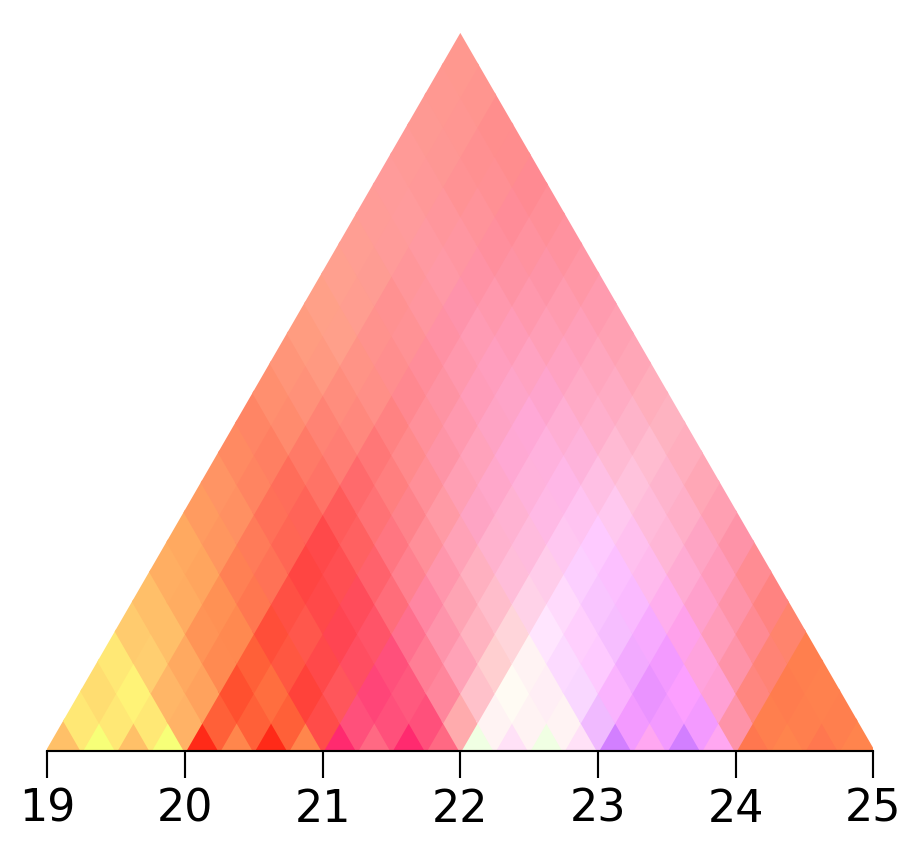

In [14]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          tick_ratio=4, tick_offset=0, subparts_highlighted=[72,96])

As can be seen, if the parameters relating to the ticks are provided, they stay consistent with the zoom-in. The vertical indicators for the hierarchical level do not work with this feature, and even if the parameter is provided, the function won't draw them on the zoom-in. 

The parameter `subparts_highlighted` also can expect to receive a list of regions (still in onset-offset tuple fashion) and displays highlights over the regions by the means of black outlines. For instance, let's highlight the region on which we just zoomed in and the first two bars of the Prelude; that would require to give the value `[[0,8], [72,96]]` to the parameter, assuming an analysis window of one quarter note:

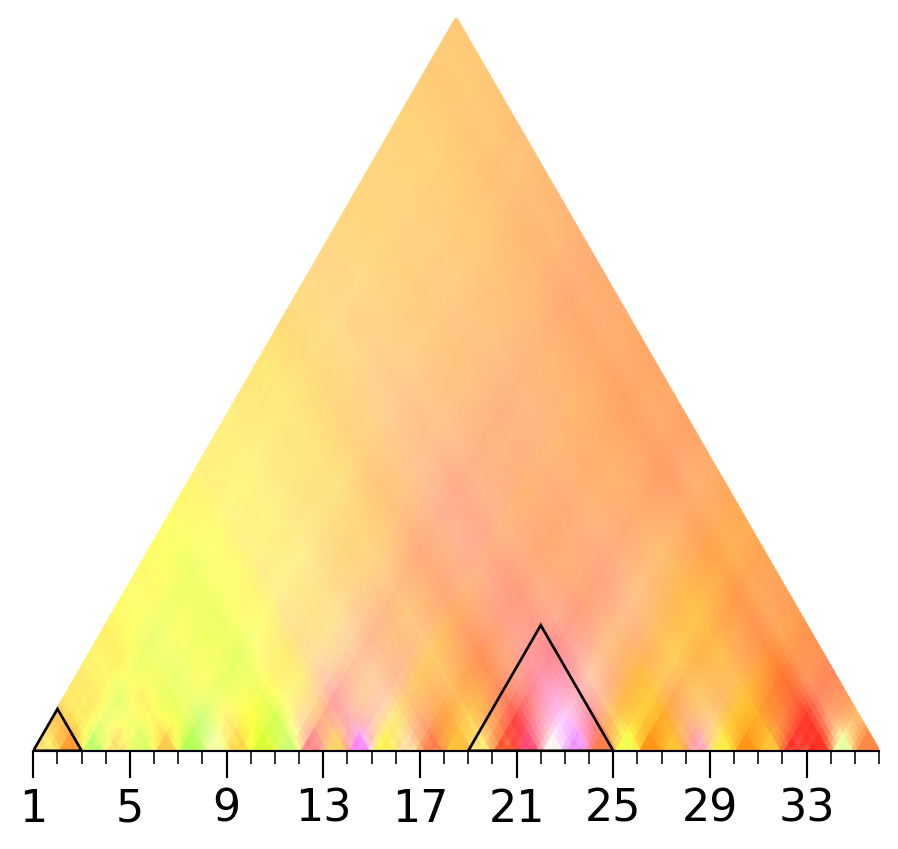

In [15]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          tick_ratio=4, tick_offset=0, subparts_highlighted=[[0,8],[72,96]])

As many tuples as wanted in any order can be given in this list, and the zone they represent can overlap without any restriction:

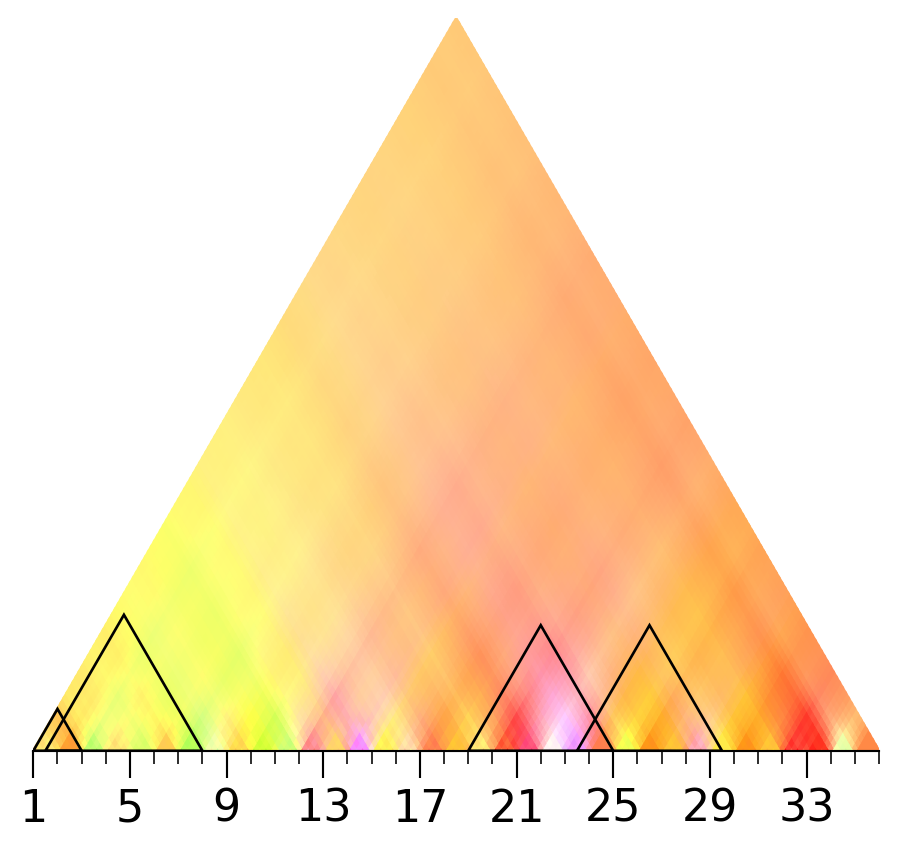

In [16]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          tick_ratio=4, tick_offset=0, subparts_highlighted=[[0,8],[72,96],[2,28],[90,114]])

<a id='cosmetic'></a>
# Cosmetic changes

There is some parameters in this library whose functions are purely cosmetic, without bringing any analytical insight: 

The first is `add_line`, which as its name indicates, add an outline on all the elements (often called 'primitive'here) of the wavescape. It expects a positive float/integer, and represents the width of the outline to be drawn. Its default value is None (meaning no outlines to be drawn).

Then there is `drawing_primtive` which dictates what shape each elements of the wavescape is drawn in. Three values are supported yet:

1. 'rhombus': default value, diamond that is formed by the union of two equilateral triangles. Makes the whole wavescape plot into the shape of an equilateral triangle

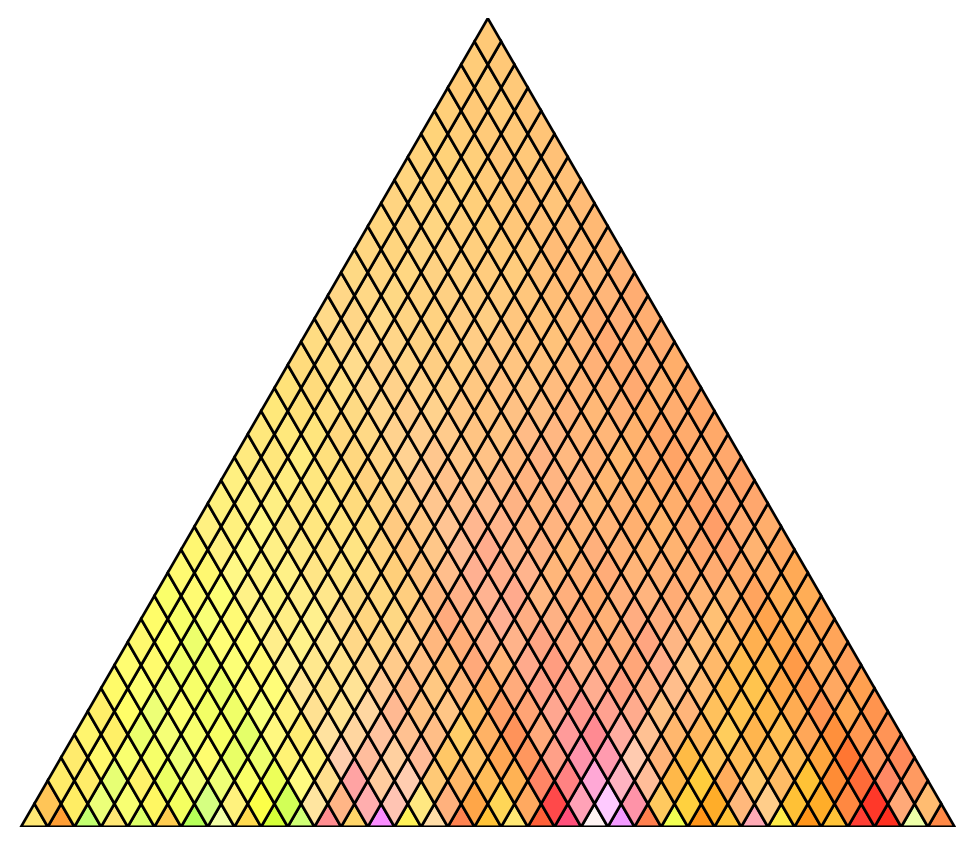

In [17]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='rhombus', add_line=1)

2. 'diamond': diamond that is twice as tall as it is wide. Can be useful to give more visual weight to the hierarchy in the plot.

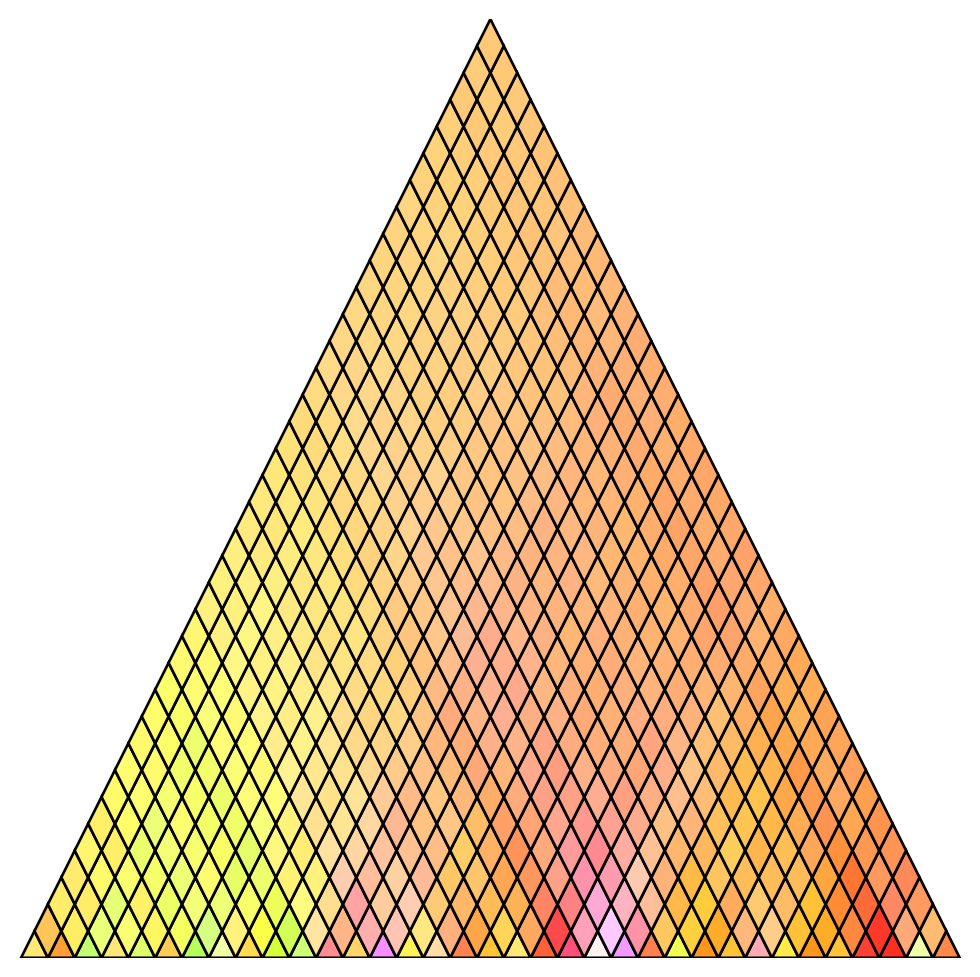

In [18]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='diamond', add_line=1)

3. 'hexagon': pretty self-explanatory, the shape of the hexagon allow individual hierarchical levels to be more easily observable.

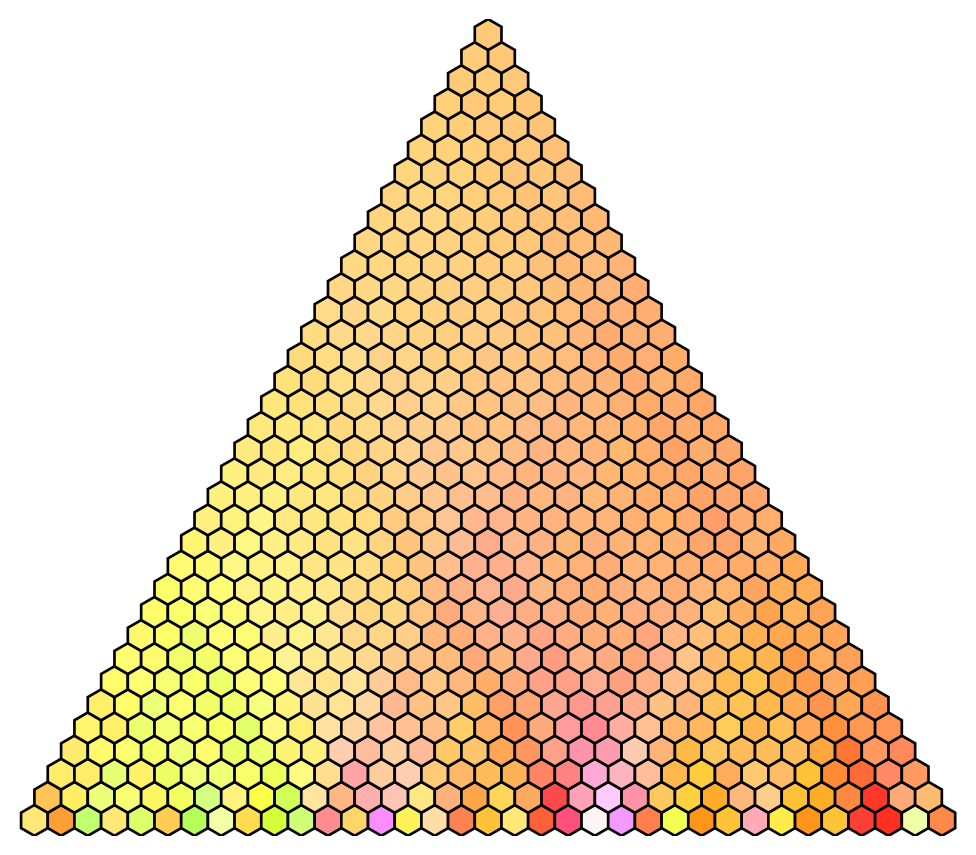

In [19]:
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='hexagon', add_line=1)

Finally, the boolean parameter `output_rgba`, as it names implies, indicates whether the resulting image is in RGBA, or RGB format. By default `output_rgba` is set to the value `False`, meaning the function hardcode a white background for the opacity mapping to be expressed in RGB format during the production of colors. If this parameter is set to `True` then the resulting image is in RGBA format, and the opacity is mapped to the alpha channel, achieving "True opacity".

There is a caveat, because of the way matplotlib rasterizes polygons, seams appear between the primitives in RGBA mode, even without setting `add_line` to any value. Increasing the width in pixels (`pixel_width`) mitigate those seams, but the best solution is 'assume' them by setting the `add_line` parameter to some value. To demonstrate this parameter here is a code snippet that adds a black background:

<Figure size 432x288 with 0 Axes>

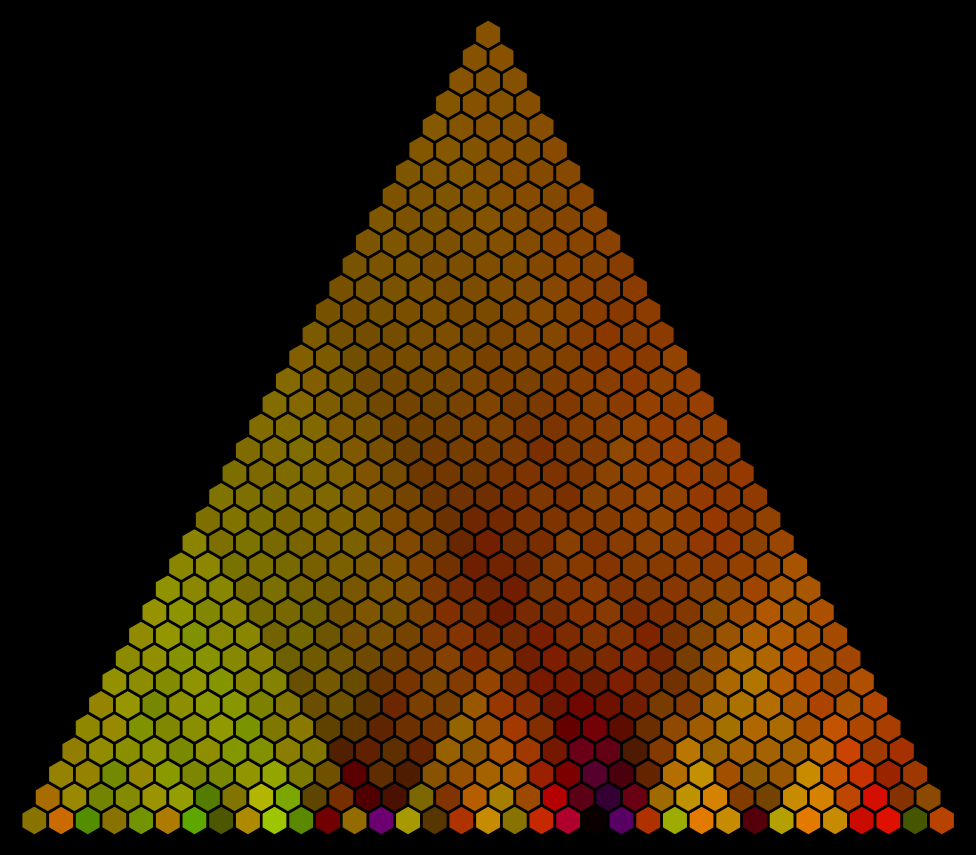

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rcParams['figure.facecolor'] = 'black'
generate_single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='hexagon', add_line=1, output_rgba=True)

#reset it to default parameter
plt.rcParams['figure.facecolor'] = 'white'

<a id='saving'></a>
# Saving

The plot produced

<a id='other'></a>
# Other parameters

Although not applicable 